### Fetching Data

In [19]:
# from SoccerNet.Downloader import SoccerNetDownloader as SNdl
# mySNdl = SNdl(LocalDirectory="path/to/SoccerNet")
# mySNdl.downloadDataTask(task="jersey-2023", split=["train","test","challenge"])


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
import pathlib
import tensorflow as tf
import numpy as np
import os
import keras
import json
import cv2
from matplotlib import pyplot as plt
import zipfile

In [21]:
"""
This function will load the data and return two zipped arrays: 

output:       contains an image stored as a numpy array
class_labels: contains the corresponding label for each element of output

@params
dir: should be the path that contains both train images, and json dic with labels
save: If you want it to save the output as a zip file (so you don't have to do this twice)
"""

def load_data(dir, save = False):

    #labels is a dictionary mapping file_numer ->class_label
    with open(dir + "/train_gt.json") as file:
        labels = json.load(file)

    #converts an image to a numpy array
        
    """
    Eventually we will want to resize the images when we localize. This is just so that they are all the same size.
    """
    get_image = lambda file_name: cv2.resize(cv2.imread(file_name),(40, 100))

    output = []
    class_labels = []

    #iterate through the folders, convert the images to RGB arrays, and then append the class label
    for folder in list(os.listdir(dir+"/images")):

        if folder == '.DS_Store': continue
        #if (folder != '1' and folder != '2'): continue

        cls = labels[folder]
        images = os.listdir(os.path.join(dir+"/images", folder))

        for image in images:
            output.append(get_image(os.path.join(dir+"/images", folder, image)))
            class_labels.append(cls)

    zip_file = zip(output, class_labels)
    if save:
        np.savez_compressed(dir+"/numpy_data.npz", output, labels)
        
    return zip_file


In [22]:
def load_small_data(dir):

    data = np.load(dir)
    lst = data.files
    X = data[lst[0]]
    y = data[lst[1]]

    return X,y

In [23]:
#X,y = zip(*load_data("/Users/omarafifi/Downloads/Jersey Detection/train", False))
X,y = load_small_data('/Users/omarafifi/Downloads/Jersey Detection/train/jersey_sample.npz')

### Preprocessing

In [24]:
from keras import Sequential
from keras.utils import to_categorical
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, ZeroPadding2D
from sklearn.model_selection import train_test_split

In [64]:
# right now, there is no data processing. 
# But, We need to make sure that all the images have the same shape.
# and one hot encode y labels
def process_data(X_data, y_data):

    """
    Prepare the response:

    This part of the function just basically maps the classes to the set {0, ... 44}, and then one-hot encodes the response
    """
    #for to_categorical to work, we need to map the labels to {0, ... 44}
    label_to_int = {}
    int_to_label = {}

    for index, label in enumerate(np.unique(y_data)):
        label_to_int[label]=index
        int_to_label[index]=label

    
    y_data_new = np.vectorize(label_to_int.__getitem__)(y_data)
    y_data_new = to_categorical(y_data_new)

    #X_train, y_train = zip(*load_data(directory, True))
    X_data = np.array(X_data).reshape(-1, 3, 100, 40)


    return X_data, y_data_new


In [65]:
X_processed, y_processed = process_data(X,y)
X_train, X_test, y_train, y_test = train_test_split(X_processed, y_processed)

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X_processed, y_processed)

### Prepare data

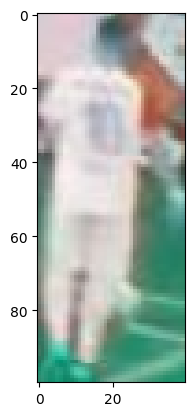

In [72]:
plt.imshow(X_train[82].reshape(100,40,3))

### Model Construction

In [56]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (4,4), activation = 'relu', input_shape = (100,40,3)))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(filters = 32, kernel_size = (4,4), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(filters = 128, kernel_size = (4,4), activation = 'relu'))
model.add(Flatten())

model.add(Dense(units = 128, activation = 'relu'))
model.add(Dense(units = 45, activation = 'softmax'))

model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics=['Accuracy'])

In [57]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 97, 37, 32)        1568      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 48, 18, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 45, 15, 32)        16416     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 22, 7, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 19, 4, 128)        65664     
                                                                 
 flatten_1 (Flatten)         (None, 9728)             

### Fit the model

In [ ]:
model.fit(x = X_train, batch_size=5, epochs=10, y = y_train)

In [ ]:
print(f"training error:{model.evaluate(X_train, y_train)}")
print(f"testing error:{model.evaluate(X_test, y_test)}")

859/859 [==============================] - 8s 9ms/step - loss: 1.0314 - Accuracy: 0.6945
training error:[1.0313957929611206, 0.6945101022720337]
287/287 [==============================] - 3s 9ms/step - loss: 2.9543 - Accuracy: 0.4302
testing error:[2.9543027877807617, 0.4302084445953369]


### The Spacial Transformer Network:

In [93]:
from sp_module import Net
from train import Network_Trainer
import torch
from torch.utils.data import TensorDataset

In [104]:
spt = Net()


tensor_x = torch.Tensor(X_train) # transform to torch tensor
tensor_y = torch.Tensor(y_train)
DataSet = TensorDataset(tensor_x, tensor_y)


trainer = Network_Trainer(spt, data = DataSet, batch_size= 100, device = 'cpu',  optimizer = 'SGD' )

Running On CPU


In [ ]:
trainer.train_model(5)

## Things To do: 

1) Use GridSearchCV to impletent CV so we can tune hyperparamaters